# Week 02 - Indexing 

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

In this tutorial we will learn about genome indexing with hash tables.
    
</div>

## Setup

**Week 2 workspace**

Ensure you have cloned COMP90014_2025 GitHub repository [https://github.com/melbournebioinformatics/COMP90014_2025.git](https://github.com/melbournebioinformatics/COMP90014_2025.git)

VSCode IDE Setup:
1. Open VSCode and open week2 directory <small>`COMP90014_2025/tutorials/week2`</small> using "File" -> "Open Folder...". 
2. Open the .ipynb file and ensure the kernel is set to your new 'venv' environment for week2 (top right). 


**Week 2 data**

This week we will be aligning a DNA read sequence to a viral genome.

No extra download is needed if you clone the GitHub repository. The data is at <small>`COMP90014_2025/tutorials/week2/data`</small> folder. You should be able to see them in the left panel.

If you are referring from iPython notebook folder, you can use <small>`data/phi-X174-420bp.fa`</small> etc.

If you wish to download manually, they are [phi-X174-420bp.fa](https://github.com/melbournebioinformatics/COMP90014_2025/blob/master/tutorials/week2/data/phi-X174-420bp.fa?raw=true) and [phi-X174-genome.fa](https://github.com/melbournebioinformatics/COMP90014_2025/blob/master/tutorials/week2/data/phi-X174-genome.fa?raw=true)

**Python environment**

Create a python environment for this tutorial. <br>
It should be located in your new 'week2' directory.

This week we need:
- ipykernel
- requests
- biopython
- matplotlib
- tqdm

<div style="font-size: 16px">

(Bash Shell)
> ```Bash
> # check you are in the week2 directory.
> pwd
> cd ~/COMP90014/tutorials/week2  # (change directory if required)
> 
> # NOTE: 
> # the following command may return 'miniconda' | 'conda' etc in the python path. 
> # if so, first try to solve using `conda config --set auto_activate_base false` then restarting your shell. 
> # if unsuccessful, you can specify the exact python binary to use. 
> # a version of python should be present in /usr/bin, or /usr/local/bin.
> # for example /usr/bin/python, or /usr/bin/python3.10, or /usr/local/bin/python3.
> # on macOS, python may also be found at /Library/Frameworks/Python.framework/Versions/[version]/bin.
> # for example /Library/Frameworks/Python.framework/Versions/3.11/bin/python3.
> 
> # check your python is correct.
> which python3
> > /usr/bin/python3
> python3 -V 
> > Python 3.11.5
>
> # use the venv module to create a virtualenv. 
> # calling `python -m venv` runs the venv module, and the final 'venv' specifies the name of the environment
> python3 -m venv venv
> 
> # activate the environment to begin working 
> # note: only activates in your current shell. if using VSC / Jupyter Lab, ensure you select it as the 'kernel'.
> source venv/bin/activate 
> 
> # check the environment is clean (should only list pip and setuptools)
> pip list 
> 
> # Install packages for this week. If using Jupyter Lab, swap 'ipykernel' for 'jupyterlab'.
> pip install ipykernel requests biopython matplotlib tqdm
>
> # check the environment now has the required packages (should list a bunch of packages)
> pip list 
> 
> ```

</div>

**Final check**

Your 'week2' directory should now have 3 things: 
- The tutorial <small>`.ipynb`</small> notebook
- A week2 slides
- A <small>`venv`</small> folder for your python environment
- A <small>`data`</small> folder containing the viral genome & read sequence. 

You can use the file explorer in VSC to confirm.

</div>

# Generators and iterators

We're going to introduce a new kind of Python object - generators. A generator is a special function that uses `yield` to produce one value at a time, pausing and remembering its state between calls, so you can iterate through (even huge) sequences without loading everything into memory.

A generator function is easy to recognize as it uses the `yield` keyword rather than the `return` keyword to return values.

Here's a (normal) function that returns a list of k-mers.

In [128]:
def get_kmers_list(text, k):
    ''' 
    Return a list of all k-mers of length k from string t.
    K-mers may be non-unique.
    '''
    result = []
    for i in range(len(text) - k + 1):
        kmer = text[i : i + k]
        result.append(kmer)
    return result

In [129]:
get_kmers_list('BANANA', 3)

['BAN', 'ANA', 'NAN', 'ANA']

In the above function, the `result` object can be a huge list if `text` is large. Human reference genome has a memory footprint of around 3GB. For k = 30, the `results` object is roughly 90GB, infeasible for regular computers.

Here's a *generator function* that returns all the k-mers in the string, but only calculates each one as it is asked for. Every time the function reaches the `yield` keyword, it makes a new value available, which is consumed by whatever we are using to iterate, such as a `for` loop. At no point do we need to store the whole list of k-mers in memory!

In [130]:
def get_kmers_iterator(text, k):
    ''' 
    Return a generator yielding all k-mers of length k from string t.
    K-mers may be non-unique.
    '''
    for i in range(len(text) - k + 1):
        kmer = text[i : i + k]
        yield kmer

Notice we yield the kmers one at a time. We don't try to return the whole list at once. There is no list!

Every iteration in a `for` loop, the function resumes running from where it left off and runs until it gets to a `yield` statement.

This gives us a generator, which is iterable:

In [131]:
for kmer in get_kmers_iterator('BANANA', 3):
    print(kmer)

BAN
ANA
NAN
ANA


In [132]:
# There is no list
print(get_kmers_iterator('BANANA', 3))

<generator object get_kmers_iterator at 0x74fda3da09a0>


Convert the generator to list, which stores everything in memory.

In [133]:
list(get_kmers_iterator('BANANA',3))

['BAN', 'ANA', 'NAN', 'ANA']

We can still assign the generator to a variable (if we want to)

In [134]:
kmers = get_kmers_iterator('BANANA', 3)
print(kmers)

<generator object get_kmers_iterator at 0x74fda3da05e0>


Unlike with a list, Python can't tell us how many k-mers are going to be returned in total, as it hasn't built a list - it doesn't know what any of the k-mers are yet.

In [135]:
# Try: len(kmers)

In [136]:
for kmer in kmers:
    print(kmer)

BAN
ANA
NAN
ANA


This concept is very useful if we want to iterate over large number of k-mers or suffixes and store them in a more concise data structure, and don't want to hold them all in memory in the meantime.

The itertools module provides lots of handy iterators, and ways to create them. E.g.:

In [137]:
import itertools

yesno_forever = itertools.cycle(['yes', 'no'])
count = 0
for x in yesno_forever:
    print(x)
    count += 1
    if count > 5:
        # This gets us out of the for loop
        break

yes
no
yes
no
yes
no


`enumerate()` can also work with iterators:

In [138]:
kmers = get_kmers_iterator('BANANA', 3)
for (i, kmer) in enumerate(kmers):
    print(i, kmer)

0 BAN
1 ANA
2 NAN
3 ANA


In [139]:
kmers = get_kmers_iterator('BANANA', 3)

list(enumerate(kmers))

[(0, 'BAN'), (1, 'ANA'), (2, 'NAN'), (3, 'ANA')]

# Hash tables

### Why use hash tables?

Hash tables allow us to look up data in constant time, O(1), by reserving a specified number of locations in memory and storing data based on a memory address (or index) that is generated from a key value. The key part of a hash table is the hash function, which maps the input to a numeric value, corresponding to the memory address where the item is stored.

### Properties of Hash Function

- Deterministic: Same input always yields the same output.

- Efficiency: Runs in time close to linear in input length; low constant factors.

- Fixed-length output: Produces a compact, fixed-size digest.

- Uniformity: Outputs are evenly distributed over the range.

### Dictionaries are hash tables

Python dicts **ARE** already a hashtable so will hash whatever values we set as keys and create their own hash index in the background.

You can use `my_dict = dict()` to define a dictionary, and use `my_dict[key] = value` to insert key-value pairs.

To understand how Python hash tables work you can check out this [post](https://realpython.com/python-hash-table).

# Hashing DNA strings

As DNA is double stranded and can be arbitrarily read in either direction we typically choose one of the two possible orientations to represent a given kmer. This is call the "canonical" kmer and is chosen as the lexicographically smaller of the two kmers.

In [140]:
from Bio.Seq import Seq

# Create a new seq object
fwd = Seq('ATG')
rev = fwd.reverse_complement()
print(fwd)
print(rev)

ATG
CAT


In [141]:
# In this case ATG is smaller than CAT
fwd <= rev

True

Having selected our canonical kmer we will run our hash function and then the modulo operation to find the memory address for this kmer in a hash table with 10 slots.

In [142]:
# We can use Python's built in hash function for this.
# but beware, hash() will not return consistent values between different sessions!

print(f'The hash of ATG is: {hash(fwd)}')
print(f'The memory address in a hashtable of size 10 is: {hash(fwd) % 10}')

The hash of ATG is: -1559551577261781487
The memory address in a hashtable of size 10 is: 3


# Kmer index via hash table

In this section you will build a hash table to store and retrieve the locations of kmers within a DNA sequence.

Your "hash table" will be constructed as a Python dict with memory addresses (indices) as dictionary keys and kmer locations stored under these locations as tuples with the canonical kmer and a list of kmer locations.


In our previous example 'ATG' had an index of 2. 'ATG' occurs twice in the seq 'ATGATG' at positions 1 and 4.

It would be stored in our dict as:

`HashTable[2] = ('ATG',[1,4])`


Where collisions occur you should use linear probing to locate an alternative memory slot to store the kmer and its locations.



## Task 1 - Get canonical kmers

<div class="info">

<b>Task 1:</b> Write a function to return the lexicographically smaller of the two orientations of a DNA sequence.
    
- [ ] Take Biopython Seq object as input
- [ ] Compare the kmer to its reverse complement 
- [ ] Return the lexicographically smaller of the two kmers
</div>

In [143]:
from Bio.Seq import Seq
def get_canon(kmer):
    fwd = Seq(kmer)
    rev = fwd.reverse_complement()
    if fwd <= rev:
        return fwd
    else:
        return rev

## Task 2 - Extract kmers and their locations

<div class="info">

<b>Task 2:</b> Write a function that takes as input a Seq object and returns a list of (kmer,position) pairs.

- [ ] Input: Biopython Seq object; and kmer length 'k'.
- [ ] Extract kmers  
- [ ] Output: tuples of (kmer,position) pairs
- [ ] Output may be a list or an iterator
    
<b>Bonus challange:</b> Modify your function to skip any kmer containing the character 'N' which signifies an unknown base.
    
    
Notes: 
- Enumerate will not work inside a `yield` statement.
- If you choose to write this function as an iterator remember it can only be consumed once.

</div>

In [144]:
def kmer_locs(sequence, k = 5):
    results = []

    for i in range(len(sequence)-k):
        results.append((i, get_canon(sequence[i:i+k])))

    final = []

    for number,sequence in results:
        if 'N' not in sequence:
            final.append((number, sequence))
        
    return final    
    

In [145]:
# Test it out
[print(k, i) for k, i in kmer_locs(Seq('ATGGNGTCGGNTTTT'), k = 4)]

0 ATGG
5 CGAC
6 CCGA


[None, None, None]

### Comparee the space complexity between `yield` and `return`

Here we will rewrite the function using return instead of yield, and compare the complexity.

In [146]:
def kmer_locs_in_memory(sequence, k = 5):
    kmer_list = []

    for i in range(len(sequence) - k + 1):
        kmer = sequence[i : i + k]
        if 'N' in kmer:
            continue
        else:
            kmer_list.append((kmer, i))
    return kmer_list

100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


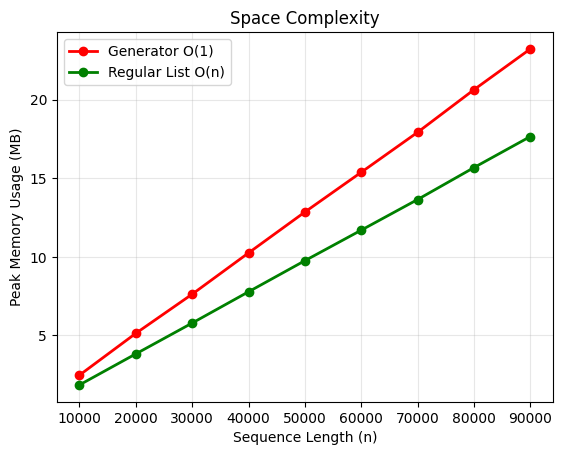

In [147]:
# Space complexity compare
import tracemalloc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Randopm sequence generator
def generate_dna_sequence_numpy(length):
    nucleotides = ['A', 'T', 'C', 'G']
    return Seq(''.join(np.random.choice(nucleotides, size = length)))

# Helper function to measure space complexity - similar to week1
def measure_space_complexity(kmer_func, sequence):
    """Measure peak memory usage during sorting"""
    peak_memories = []
    # Start memory tracking
    tracemalloc.start()
    # Run the sorting algorithm
    kmer_func(sequence)
    # Get peak memory usage
    current, peak = tracemalloc.get_traced_memory()
    peak_memories.append(peak)
    # Stop memory tracking
    tracemalloc.stop()
    # Return average peak memory usage in bytes
    return sum(peak_memories) / len(peak_memories)

# Test different array sizes
n_items = list(range(10000, 100000, 10000))

# Measure space complexity
generator_space = []
list_space = []

# For loop wih progress bar
for n in tqdm(n_items):
    # Generate test array
    long_dna_sequence = generate_dna_sequence_numpy(n)
    # Measure space for selection sort
    space_yield = measure_space_complexity(kmer_locs, long_dna_sequence)
    generator_space.append(space_yield / 1024 / 1024)
    # Measure space for merge sort  
    space_return = measure_space_complexity(kmer_locs_in_memory, long_dna_sequence)
    list_space.append(space_return / 1024 / 1024)

plt.plot(n_items, generator_space, 'r-o', label='Generator O(1)', linewidth=2)
plt.plot(n_items, list_space, 'g-o', label='Regular List O(n)', linewidth=2)
plt.title('Space Complexity')
plt.xlabel('Sequence Length (n)')
plt.ylabel('Peak Memory Usage (MB)')
plt.legend()
plt.grid(True, alpha=0.3)

## Task 3 - Populate hashtable with kmer locations

<div class="info">

<b>Task 3:</b> 
    
Write a function that takes a list of (kmer, location) tuples as input and inserts them into a python dictionary. 
    
Return a dict with the structure:

`kmer_dict[index] = (kmer, [locations])`

Your function should: 
- [ ] Input: 
    - List of (kmer, location) tuples; 
- [ ] Treat the kmer as a Bio.Seq object
- [ ] Convert each kmer to its canonical form 
- [ ] Check if the canonical kmer is already in the dict
- [ ] Append the location to the list if occupied, create new list otherwise
- [ ] Output: return your dictionary

Notes: 
- Python dictionary will overwrite the value if the key already exists

</div>

In [167]:
def build_hash_table(kmer_list):
    dict = {}
    for location, kmer in kmer_list:
        dict.setdefault(kmer, location)

    return dict   

In [168]:
# Example usage:
kmer_list = kmer_locs(Seq('ATGGNGTCGGNTTTTATATCTGTCTCGATATAGCCGAGCGCTCGCATCA'), k = 3)
test_hash_table = build_hash_table(kmer_list)
test_hash_table

{Seq('ATG'): 0,
 Seq('CCA'): 1,
 Seq('GAC'): 5,
 Seq('CGA'): 6,
 Seq('CCG'): 7,
 Seq('AAA'): 11,
 Seq('TAA'): 13,
 Seq('ATA'): 14,
 Seq('ATC'): 17,
 Seq('AGA'): 18,
 Seq('CAG'): 19,
 Seq('ACA'): 20,
 Seq('CTC'): 23,
 Seq('CTA'): 30,
 Seq('AGC'): 31,
 Seq('GCC'): 32,
 Seq('CGC'): 37,
 Seq('GCA'): 43}

# Map a long read to a genome

We have a long read `phiX_read` that has been obtained by sequencing the PhiX bacteriophage genome `phiX_genome`.

There are some sequencing errors in this read so it does not match the genome perfectly. 

Your challange is to figure out where the read maps to by:

A) Building a hashtable index of the PhiX genome, and 

B) Extracting kmers from the sequencing read and looking up their location/s in the genome index.



First, we will import these sequences using Biopython as SeqRecord objects. <br>
Explore the attributes of this object.
Where is the sequence stored?

In [175]:
from Bio import SeqIO

# Import with biopython as seqrecord objects
phiX_read = SeqIO.read('data/phi-X174-420bp.fa', "fasta")
phiX_genome = SeqIO.read('data/phi-X174-genome.fa', "fasta")

If you wanted to manually read in a single fasta record as a string, you could do this:

In [176]:
# Or read it ourselves, assuming a file with one FASTA record
with open('data/phi-X174-genome.fa') as f:
    _identifier_row = f.readline()
    # Read the rest of the lines and join them into one string
    phiX = ''.join([row.strip() for row in f.readlines()])

Next, we will use functions that we wrote in the previous section to build an hash table index for the PhiX genome.

In [177]:
# Extract kmers and their locations from the PhiX genome
genome_kmers = kmer_locs(phiX_genome.seq, k = 4) 
# Note: The phiX_genome is a SeqRecord we need to access the Seq attribute using '.seq'

# Index the PhiX genome using your build_hash_table() function
genome_hash_table = build_hash_table(genome_kmers)

<div class="info">

<b>Challange:</b> Write a <b>generator</b> function that extracts kmers from a query sequence and looks up their location/s from a precalculated hashtable.
    
- [ ] Inputs:
    - A query read as Bio.Seq object,
    - A genome index (hashtable),
    - The length k used to build the index,
    - The size of the hashtable.
- [ ] Output: <i>yield</i> (x, y) tuples where x is a kmer location in the read and y is the location of that kmer in the genome.

**Note:** If a kmer occurs many times in the genome you should return all locations i.e. `[(x1, y1), (x1, y2)...]`
</div>

In [179]:
def mapKmers(read, hash_table = {}, k = 3):
    results = []
    query = kmer_locs(read, k)

    for location, kmer in query:
        read_kmer = str(kmer)
        y = hash_table.get(read_kmer)
        if y is not None:
            x = location
            results.append((x,y))

    return results

Finally use matplotlib to plot the list of (x, y) coords that were generated by the previous function as a scatterplot.

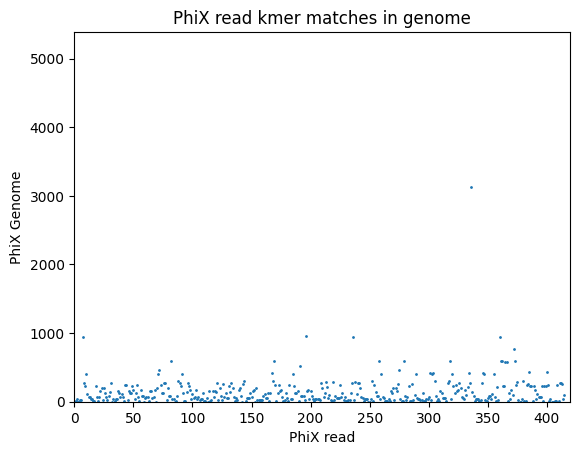

In [181]:
%matplotlib inline
import matplotlib.pyplot as plt

# Let's assign the output of our mapping function to a variable
xy_generator = mapKmers(read = phiX_read.seq, 
                        hash_table = genome_hash_table, 
                        k = 4)

# Lists to store x and y values
x_values = []
y_values = []

# Iterate over the generator and extract the x and y values
for x, y in xy_generator:
    x_values.append(x)
    y_values.append(y)

# Create the scatter plot
plt.scatter(x_values, y_values, s = 1)
plt.xlim(0, len(phiX_read.seq))
plt.ylim(0, len(phiX_genome.seq))
plt.xlabel('PhiX read')  # Add X-axis label if needed
plt.ylabel('PhiX Genome')  # Add Y-axis label if needed
plt.title('PhiX read kmer matches in genome')
plt.show()

This should look like a right mess! We have used a very small kmer size to compare our read to the genome.



Let's rebuild our genome index using a larger value of k to see if we can improve the specificity of our matches.

Remember to increase the size of the hash table to accomodate the extra kmers!

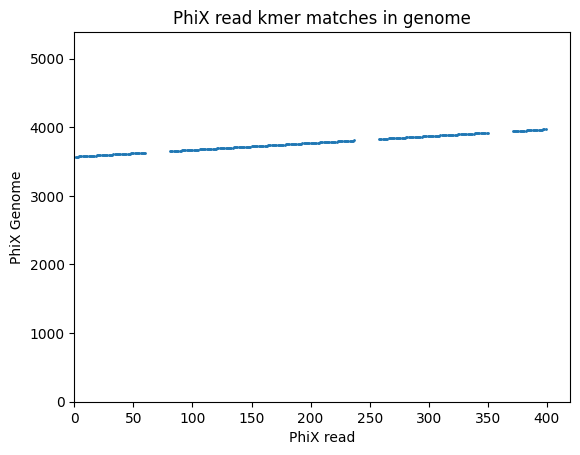

In [182]:
# Increase the size of k to improve the specificity of our read mapping
# You may also need to increase the hash table size to accomodate all the new kmers!
k = 20
table_size = 10000


# Extract kmers and their locations from the PhiX genome
genome_kmers = kmer_locs(phiX_genome.seq, k = k) 
# Note: The phiX_genome is a SeqRecord we need to access the Seq attribute using '.seq'

# Index the PhiX genome using your build_hash_table() function
large_genome_hash_table = build_hash_table(genome_kmers)

# Let's assign the output of our mapping function to a variable
xy_generator = mapKmers(read = phiX_read.seq, 
                        hash_table = large_genome_hash_table, 
                        k = k)

# Lists to store x and y values
x_values = []
y_values = []

# Iterate over the generator and extract the x and y values
for x, y in xy_generator:
    x_values.append(x)
    y_values.append(y)

# Create the scatter plot
plt.scatter(x_values, y_values, s=1)
plt.xlim(0, len(phiX_read.seq))
plt.ylim(0, len(phiX_genome.seq))
plt.xlabel('PhiX read')  # Add X-axis label if needed
plt.ylabel('PhiX Genome')  # Add Y-axis label if needed
plt.title('PhiX read kmer matches in genome')
plt.show()

Workshop developed by Adam Taranto, Liwen Li, and Grace Hall.